In [108]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV


from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    precision_score,
    recall_score,
    average_precision_score, 
    roc_auc_score
)

from catboost import CatBoostClassifier

import shap

def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)


## Feature Selection

In [6]:
train_data = pd.read_csv("./../data/processed/train_processed.csv")
test_data = pd.read_csv("./../data/processed/test_processed.csv")

print(train_data.shape, test_data.shape)

## Preprocess the target
def handle_target(x, thresh=3.5):
    
    if x < thresh:
        return 0
    else:
        return 1
    
train_data["Stars"] = pd.to_numeric(train_data["Stars"], errors='coerce').fillna(-1).astype(float).apply(handle_target)
test_data["Stars"] = pd.to_numeric(test_data["Stars"], errors='coerce').fillna(-1).astype(float).apply(handle_target)


X_train, y_train = train_data.drop(["Stars"], axis=1), train_data["Stars"]
X_test, y_test = test_data.drop(["Stars"], axis=1), test_data["Stars"]


(3160, 648) (790, 648)


Columns (647) have mixed types.Specify dtype option on import or set low_memory=False.


In [7]:
pipe_rfe_ridgecv = RFECV(Ridge(), cv=2)
pipe_rfe_ridgecv.fit(X_train, y_train)

display(mean_std_cross_val_scores(pipe_rfe_ridgecv, X_train, y_train, return_train_score=True))

X does not have valid feature names, but RFECV was fitted with feature names
X does not have valid feature names, but RFECV was fitted with feature names
X does not have valid feature names, but RFECV was fitted with feature names
X does not have valid feature names, but RFECV was fitted with feature names
X does not have valid feature names, but RFECV was fitted with feature names
X does not have valid feature names, but RFECV was fitted with feature names


fit_time       25.960 (+/- 0.988)
score_time      0.008 (+/- 0.000)
test_score      0.065 (+/- 0.024)
train_score     0.289 (+/- 0.051)
dtype: object

In [ ]:
# pipe_rfe_ridgecv.get_feature_names_out(), pipe_rfe_ridgecv.n_features_

In [8]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1, perc=90)
feat_selector.fit(X_train.values, y_train)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	647
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	77
Tentative: 	66
Rejected: 	504
Iteration: 	9 / 100
Confirmed: 	77
Tentative: 	66
Rejected: 	504
Iteration: 	10 / 100
Confirmed: 	77
Tentative: 	66
Rejected: 	504
Iteration: 	11 / 100
Confirmed: 	77
Tentative: 	66
Rejected: 	504
Iteration: 	12 / 100
Confirmed: 	77
Tentative: 	45
Rejected: 	525
Iteration: 	13 / 100
Confirmed: 	77
Tentative: 	45
Rejected: 	525
Iteration: 	14 / 100
Confirmed: 	77
Tentative: 	45
Rejected: 	525
Iteration: 	15 / 100
Confirmed: 	77
Tentative: 	45
Rejected: 	525
Iteration: 	16 / 100
Confirmed: 	

BorutaPy(estimator=RandomForestClassifier(class_weight='balanced', max_depth=5,
                                          n_estimators=249, n_jobs=-1,
                                          random_state=RandomState(MT19937) at 0x14C841040),
         n_estimators='auto', perc=90,
         random_state=RandomState(MT19937) at 0x14C841040, verbose=2)

In [9]:
feature_ranks = pd.DataFrame([X_train.columns, feat_selector.ranking_, feat_selector.support_]).T
feature_ranks.columns = ["feature", "rank", "keep"]
feature_ranks["keep_ridge"] = feature_ranks.feature.apply(lambda x: True if x in pipe_rfe_ridgecv.get_feature_names_out() else False)
feature_ranks = feature_ranks.sort_values("rank")
feature_ranks

,feature,rank,keep,keep_ridge
646,yum,1,True,True
377,Brand_Sainsbury's,1,True,True
572,Country_Netherlands,1,True,True
575,Country_Pakistan,1,True,True
577,Country_Philippines,1,True,False
...,...,...,...,...
296,Brand_Nakaya Shouten,522,False,False
442,Brand_Tabate,522,False,False
145,Brand_Haogemen,522,False,True
148,Brand_Happy Noodle,522,False,True


In [11]:
features_1 = feature_ranks["feature"].to_list()
features_2 = feature_ranks[feature_ranks["keep"] == True]["feature"].to_list()
features_3 = feature_ranks[(feature_ranks["keep"] == True) | (feature_ranks.head(300)["keep_ridge"] == True)]["feature"].to_list()

len(features_1), len(features_2), len(features_3), 

Boolean Series key will be reindexed to match DataFrame index.


(647, 77, 227)

## Model Selection

In [177]:
class_weights

[0.7468354430379747, 0.25316455696202533]

In [179]:
list_feature = [x for x in train_data if x != "Stars"]

X_train, y_train = train_data[list_feature], train_data["Stars"]
X_test, y_test = test_data[list_feature], test_data["Stars"]


class_weights = (y_train.value_counts() / len(y_train)).tolist()
class_weights = [0.2, 0.3]
models={
"LogisticRegression": LogisticRegression(random_state=123, class_weight='balanced'),
"RandomForest": RandomForestClassifier(random_state=123, class_weight='balanced'),
"SVC": SVC(random_state=123, class_weight='balanced'),
"CatBoost": CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights)
}



In [180]:
rst_all = []

for features_list in [features_2, features_3, features_1]:

    rst_df=[]
    for model in models:
        print(model)
        tmp_df=pd.DataFrame(mean_std_cross_val_scores(models[model], X_train[features_list], y_train,
                                                      return_train_score=True, cv=5), columns=[model+"_"+str(len(features_list))])
        rst_df.append(tmp_df)

    rst_df=pd.concat(rst_df, axis=1)
    display(rst_df.T)
    
    rst_all.append(rst_df)


rst_all = pd.concat(rst_all, axis=1).T


LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_77,0.081 (+/- 0.034),0.003 (+/- 0.001),0.641 (+/- 0.018),0.662 (+/- 0.010)
RandomForest_77,0.432 (+/- 0.029),0.027 (+/- 0.006),0.702 (+/- 0.021),0.903 (+/- 0.005)
SVC_77,0.527 (+/- 0.016),0.326 (+/- 0.011),0.662 (+/- 0.022),0.768 (+/- 0.015)
CatBoost_77,1.499 (+/- 0.132),0.012 (+/- 0.011),0.758 (+/- 0.010),0.804 (+/- 0.005)


LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_227,0.157 (+/- 0.047),0.005 (+/- 0.002),0.697 (+/- 0.014),0.732 (+/- 0.004)
RandomForest_227,0.645 (+/- 0.034),0.032 (+/- 0.003),0.730 (+/- 0.018),0.938 (+/- 0.002)
SVC_227,0.858 (+/- 0.031),0.353 (+/- 0.068),0.721 (+/- 0.019),0.824 (+/- 0.012)
CatBoost_227,1.695 (+/- 0.241),0.018 (+/- 0.004),0.760 (+/- 0.003),0.795 (+/- 0.002)


LogisticRegression
RandomForest
SVC
CatBoost


,fit_time,score_time,test_score,train_score
LogisticRegression_647,0.197 (+/- 0.022),0.007 (+/- 0.001),0.689 (+/- 0.012),0.767 (+/- 0.003)
RandomForest_647,1.102 (+/- 0.054),0.040 (+/- 0.016),0.751 (+/- 0.015),0.976 (+/- 0.002)
SVC_647,1.968 (+/- 0.169),0.681 (+/- 0.067),0.703 (+/- 0.014),0.853 (+/- 0.007)
CatBoost_647,2.697 (+/- 0.157),0.048 (+/- 0.008),0.760 (+/- 0.005),0.788 (+/- 0.005)


In [181]:
rst_all

,fit_time,score_time,test_score,train_score
LogisticRegression_77,0.081 (+/- 0.034),0.003 (+/- 0.001),0.641 (+/- 0.018),0.662 (+/- 0.010)
RandomForest_77,0.432 (+/- 0.029),0.027 (+/- 0.006),0.702 (+/- 0.021),0.903 (+/- 0.005)
SVC_77,0.527 (+/- 0.016),0.326 (+/- 0.011),0.662 (+/- 0.022),0.768 (+/- 0.015)
CatBoost_77,1.499 (+/- 0.132),0.012 (+/- 0.011),0.758 (+/- 0.010),0.804 (+/- 0.005)
LogisticRegression_227,0.157 (+/- 0.047),0.005 (+/- 0.002),0.697 (+/- 0.014),0.732 (+/- 0.004)
RandomForest_227,0.645 (+/- 0.034),0.032 (+/- 0.003),0.730 (+/- 0.018),0.938 (+/- 0.002)
SVC_227,0.858 (+/- 0.031),0.353 (+/- 0.068),0.721 (+/- 0.019),0.824 (+/- 0.012)
CatBoost_227,1.695 (+/- 0.241),0.018 (+/- 0.004),0.760 (+/- 0.003),0.795 (+/- 0.002)
LogisticRegression_647,0.197 (+/- 0.022),0.007 (+/- 0.001),0.689 (+/- 0.012),0.767 (+/- 0.003)
RandomForest_647,1.102 (+/- 0.054),0.040 (+/- 0.016),0.751 (+/- 0.015),0.976 (+/- 0.002)


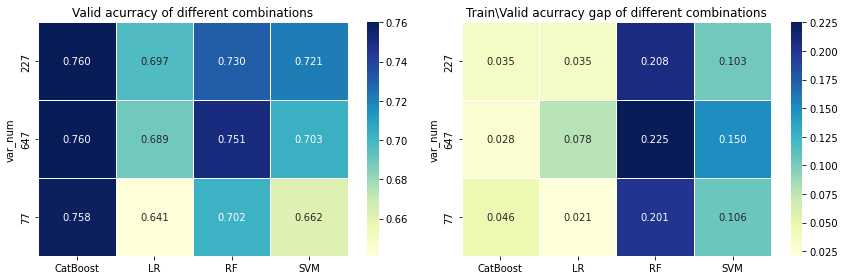

In [182]:
col_name = ["CatBoost", "LR", "RF", "SVM"]

rst_all_test = rst_all[["test_score"]].copy()
rst_all_test.loc[:, "model"] = [x.split("_")[0] for x in rst_all_test.index]
rst_all_test.loc[:, "var_num"] = [x.split("_")[1] for x in rst_all_test.index]
rst_all_test.loc[:, "test_score"] = [float(x.split("(+")[0].strip()) for x in rst_all_test.test_score]

rst_all_test = pd.crosstab(columns=rst_all_test["model"], index=rst_all_test["var_num"], values=rst_all_test["test_score"], aggfunc=sum)
rst_all_test.columns = col_name


rst_all_train = rst_all[["train_score"]].copy()
rst_all_train.loc[:, "model"] = [x.split("_")[0] for x in rst_all_train.index]
rst_all_train.loc[:, "var_num"] = [x.split("_")[1] for x in rst_all_train.index]
rst_all_train.loc[:, "test_score"] = [float(x.split("(+")[0].strip()) for x in rst_all_train.train_score]

rst_all_train = pd.crosstab(columns=rst_all_train["model"], index=rst_all_train["var_num"], values=rst_all_train["test_score"], aggfunc=sum)
rst_all_train.columns = col_name

fig, axs = plt.subplots(1, 2, figsize=(12,4))

sns.heatmap(rst_all_test, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".3f", ax=axs[0])
axs[0].set_title("Valid acurracy of different combinations")
sns.heatmap(rst_all_train - rst_all_test, cmap="YlGnBu", linewidths=.5, annot=True, fmt=".3f", ax=axs[1])
axs[1].set_title("Train\Valid acurracy gap of different combinations")

plt.tight_layout()
plt.savefig("./../results/feature_model_selection.jpg", dpi=1600)

In [183]:
from scipy.stats import expon, lognorm, loguniform, randint, uniform


pipe_cat = CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights)

param_grid = {
    "learning_rate": np.linspace(0.05,0.3,10),
    "max_depth": randint(3, 7),
    "n_estimators": [400, 500, 600, 700, 800],
    
}


rscv = RandomizedSearchCV(pipe_cat, param_grid, scoring='accuracy', cv=5, return_train_score=True)

rscv.fit(X_train[features_2], y_train)


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x153b41cd0>,
                   param_distributions={'learning_rate': array([0.05      , 0.07777778, 0.10555556, 0.13333333, 0.16111111,
       0.18888889, 0.21666667, 0.24444444, 0.27222222, 0.3       ]),
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x153b41c40>,
                                        'n_estimators': [400, 500, 600, 700,
                                                         800]},
                   return_train_score=True, scoring='accuracy')

In [184]:
print("Best hyperparameter values: ", rscv.best_params_)
print("Best score: %0.3f" % (rscv.best_score_))
rst = pd.DataFrame(rscv.cv_results_).sort_values('rank_test_score')[
        ['rank_test_score', 'mean_test_score','param_max_depth', 'param_learning_rate', 'param_n_estimators',]
        ].set_index("rank_test_score").sort_index().T

rst


Best hyperparameter values:  {'learning_rate': 0.07777777777777778, 'max_depth': 5, 'n_estimators': 600}
Best score: 0.758


rank_test_score,1,2,3,3,5,6,7,8,9,10
mean_test_score,0.758228,0.755696,0.755063,0.755063,0.753797,0.753797,0.751899,0.75,0.740823,0.736709
param_max_depth,5,4,4,3,5,6,6,4,6,6
param_learning_rate,0.077778,0.133333,0.188889,0.161111,0.133333,0.133333,0.133333,0.272222,0.244444,0.3
param_n_estimators,600,700,600,700,400,500,700,500,700,600


### Other Metrics

In [203]:
scoring = [
    "accuracy",
    "f1",
    "recall",
    "precision",
]  # scoring can be a string, a list, or a dictionary

pipe_cat = CatBoostClassifier(random_state=123, verbose=0,class_weights=class_weights, **rscv.best_params_)

scores = cross_validate(
    pipe_cat, X_train[features_1], y_train, return_train_score=True, scoring=scoring
)

df = pd.DataFrame(scores).iloc[:, 2:]
df.index = ["fold_"+str(i) for i in df.index]
df.columns = [i.replace("test", "valid") for i in df.columns]
display(df)
df.to_csv("./../results/cross_valid_metric.csv", index=False)

,valid_accuracy,train_accuracy,valid_f1,train_f1,valid_recall,train_recall,valid_precision,train_precision
fold_0,0.761076,0.831092,0.858746,0.898212,0.972458,0.997881,0.768844,0.816645
fold_1,0.743671,0.830301,0.848881,0.897881,0.963983,0.998941,0.758333,0.815391
fold_2,0.753165,0.829509,0.853659,0.897454,0.963983,0.998941,0.765993,0.814687
fold_3,0.768987,0.816851,0.862524,0.890776,0.970339,1.000000,0.776271,0.803063
fold_4,0.775316,0.820411,0.866541,0.892519,0.976695,0.998411,0.778716,0.806935


In [205]:
pipe_cat = CatBoostClassifier(random_state=123, verbose=0, **rscv.best_params_)

pipe_cat.fit(X_train[features_2], y_train)

import pickle
out_file_train = "./best_model.pkl"
print(f"Writing model in '{out_file_train}' ...")
pickle.dump(pipe_cat, open(out_file_train, "wb"))

Writing model in './best_model.pkl' ...


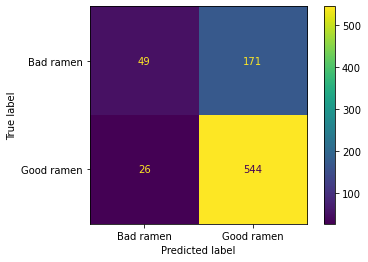

In [201]:
from sklearn.metrics import ConfusionMatrixDisplay  # Recommended method in sklearn 1.0

cm = ConfusionMatrixDisplay.from_estimator(
    pipe_cat, X_test[features_2], y_test, values_format="d", display_labels=["Bad ramen", "Good ramen"]
)

plt.savefig("./../results/confusion_matrix.jpg")

In [202]:
scoring_dict = {
    "accuracy": accuracy_score,
    "f1": f1_score,
    "recall": precision_score,
    "precision": recall_score,
}

y_test_hat = pipe_cat.predict(X_test)
y_train_hat = pipe_cat.predict(X_train)

heads, metrics = [], []
for i in scoring_dict:
    for j in [ "test", "train",]:
        if j == "train":
            y = y_train
            y_hat = y_train_hat
        else:
            y = y_test
            y_hat = y_test_hat
            
        heads.append(j+"_"+i)
        metrics.append(scoring_dict[i](y_hat, y))
        
df = pd.DataFrame([metrics], columns=heads)

df.to_csv("./../results/test_metric.csv", index=False)


In [26]:
print(
classification_report(
    y_test, pipe_cat.predict(X_test[features_2]), target_names=["Bad ramen", "Good ramen"]
)
)


              precision    recall  f1-score   support

   Bad ramen       0.83      0.09      0.16       220
  Good ramen       0.74      0.99      0.85       570

    accuracy                           0.74       790
   macro avg       0.79      0.54      0.51       790
weighted avg       0.77      0.74      0.66       790



### Coefficients

In [27]:
import shap

In [44]:
df_imp = pd.DataFrame({"feats": pipe_cat.feature_names_, "feats_fi": pipe_cat.feature_importances_}).sort_values("feats_fi", ascending=False)
df_imp

,feats,feats_fi
46,Brand_Samyang Foods,4.684971
54,noodles,3.562415
21,instant,3.243017
8,Country_Thailand,3.030580
20,goreng,2.946153
...,...,...
38,Brand_Urban Noodle,0.194906
60,udon,0.191759
34,Brand_Shan,0.135276
64,Brand_Batchelors,0.066872


['Brand_Samyang Foods',
 'noodles',
 'instant',
 'Country_Thailand',
 'goreng',
 'Style_Pack',
 'Style_Cup',
 'Country_Malaysia',
 'noodle',
 'chicken',
 'flavor',
 'yum',
 'Country_Indonesia',
 'Country_United States',
 'shoyu',
 'Brand_Nissin',
 'Brand_Nongshim',
 'seafood',
 'Style_Bowl',
 'penang',
 'flavour',
 'ramen',
 'Country_Singapore',
 'spicy',
 'rice',
 'cup',
 'Brand_Paldo',
 'laksa',
 'Brand_Mr. Noodles',
 'Country_Vietnam',
 'mushroom',
 'Style_Tray',
 'Country_Japan',
 'Country_UK',
 'shrimp',
 'mi',
 'thai',
 'style',
 'vegetarian',
 'artificial',
 'soup',
 'Country_Canada',
 'tonkotsu',
 'Brand_Sau Tao',
 'Brand_Baijia',
 'sauce',
 'sour',
 'Brand_Nona Lim',
 'Brand_Wai Wai',
 'Brand_MAMA',
 'curry',
 'oriental',
 'fried',
 'Country_South Korea',
 'Country_Australia',
 'Brand_Knorr',
 'Brand_Koyo',
 'black',
 'Brand_Vifon',
 'Brand_Indomie',
 'Brand_MyKuali',
 'vegetable',
 'Brand_Myojo',
 'Brand_Wu-Mu',
 'Country_Netherlands',
 'Country_Pakistan',
 'Brand_Saigon Ve W

In [45]:
tree_explainer = shap.TreeExplainer(pipe_cat)
train_shap_values = tree_explainer.shap_values(X_train[features_2])
test_shap_values = tree_explainer.shap_values(X_test[features_2])

In [62]:
x

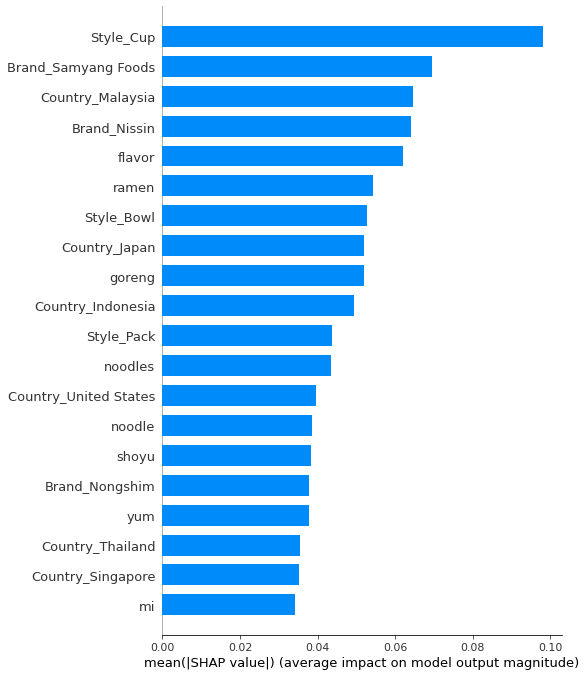

In [76]:
shap.summary_plot(train_shap_values, X_train[features_2], plot_type="bar", show=False)
plt.tight_layout()
plt.savefig('gg.jpg')


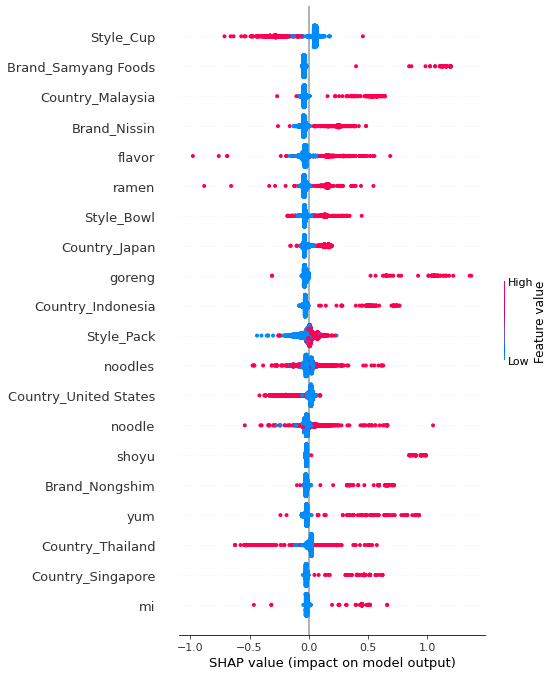

In [204]:
shap.summary_plot(train_shap_values, X_train[features_2], show=False)
plt.tight_layout()
plt.savefig('./../results/shap_explainer.jpg')


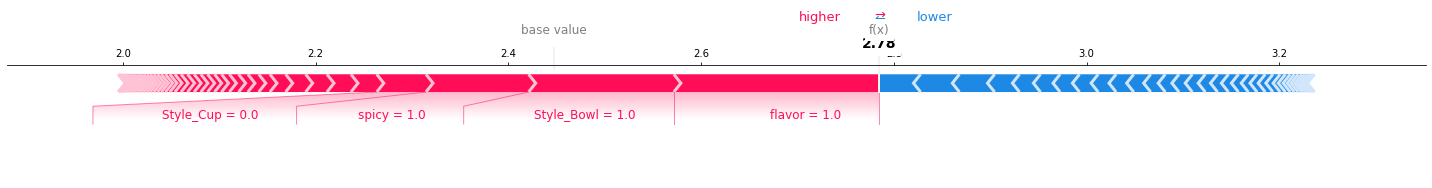

In [81]:
shap.force_plot(
    tree_explainer.expected_value,
    test_shap_values[100],
    X_test[features_2].loc[100, :],
    matplotlib=True,
    show=False
)

plt.tight_layout()
plt.savefig('gg.jpg')


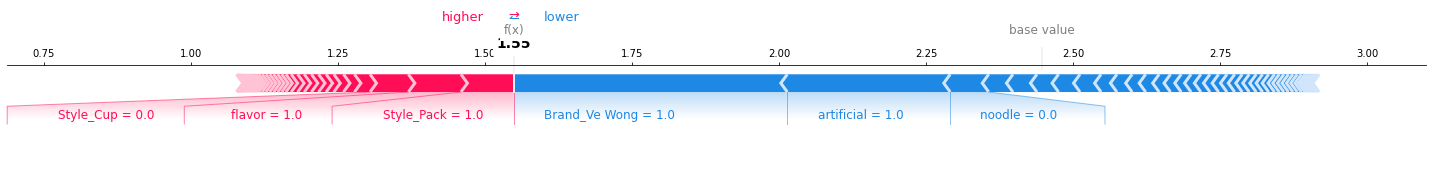

In [82]:
shap.force_plot(
    tree_explainer.expected_value,
    test_shap_values[20],
    X_test[features_2].loc[20, :],
    matplotlib=True,
    show=False
)

plt.tight_layout()
plt.savefig('gg.jpg')
